# One Node Scenarios

## Outbreak in Naive Population

In [1]:
from pathlib import Path

import numpy as np

from idmlaser.models.numpynumba import NumbaSpatialSEIR
from idmlaser.numpynumba import DemographicsByYear
from idmlaser.utils import PropertySet

meta_params = PropertySet({
    "ticks": 365,
    "nodes": 1,
    "seed": 20240625,
    "output": Path.cwd() / "outputs",
})

model_params = PropertySet({
    "exp_mean": np.float32(7.0),
    "exp_std": np.float32(1.0),
    "inf_mean": np.float32(7.0),
    "inf_std": np.float32(1.0),
    "r_naught": np.float32(14.0),
    "seasonality_factor": np.float32(0.125),
    "seasonality_offset": np.float32(182),
})

params = PropertySet(meta_params, model_params)

model = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=1, nnodes=1)
CAPACITY = 1_000_000
demographics.initialize(initial_population = CAPACITY)

max_capacity = CAPACITY
INFECTIONS = 10
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0,:] = [CAPACITY - INFECTIONS, 0, INFECTIONS, 0] # S, E, I, R
network = np.zeros((1, 1), dtype=np.float32)    # 1x1 network
model.initialize(max_capacity, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 365, 'nodes': 1, 'seed': 20240625, 'output': PosixPath('/Users/christopherlorton/projects/laser/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Seeding Numba random number generator with 10 threads
Threading layer chosen: workqueue
Initializing model with 1 nodes: (initial population: 1,000,000 maximum capacity: 1,000,000)


In [2]:
model.run(params.ticks)

  0%|          | 0/365 [00:00<?, ?it/s]

100%|██████████| 365/365 [00:01<00:00, 257.15it/s]

elapsed time: 0:00:01.441021


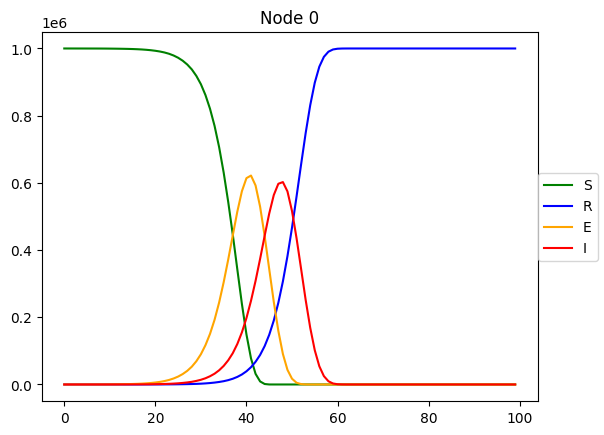

In [3]:
import matplotlib.pyplot as plt


def plot_channels(report, node=0, ticks=-1, twin=False):
    S = report[:ticks, 0, node]   # first 100 ticks, channel 0, node 0
    E = report[:ticks, 1, node]
    I = report[:ticks, 2, node]  # noqa: E741
    R = report[:ticks, 3, node]

    fig, ax1 = plt.subplots()
    plt.plot(S, label="S", color="green")
    plt.plot(R, label="R", color="blue")
    if twin:
        _ax2 = ax1.twinx()
    # _ax2.set_yscale("log")
    plt.plot(E, label="E", color="orange")
    plt.plot(I, label="I", color="red")
    plt.title(f"Node {node}")
    fig.legend(loc="center right")
    plt.show()

plot_channels(model.report, node=0, ticks=100)

## Periodicity

In [4]:
YEARS = 20
params += ({"ticks": 365*YEARS})   # override the ticks parameter
params += ({"seed": 2718281828})

model2 = NumbaSpatialSEIR(params)

# Ignore optional parameters, cbr, mortality, and immigration
demographics = DemographicsByYear(nyears=YEARS, nnodes=1)
CAPACITY = 2_000_000
demographics.initialize(initial_population = CAPACITY, cbr=18.0)

max_capacity = demographics.population[0, 0] + demographics.births[:, 0].sum()
SUSCEPTIBLE = int(CAPACITY / params.r_naught)
EXPOSED = 0
INFECTIONS = 50
RECOVERED = CAPACITY - (SUSCEPTIBLE + EXPOSED + INFECTIONS)
initial = np.zeros((1, 4), dtype=np.uint32)
initial[0,:] = [SUSCEPTIBLE, EXPOSED, INFECTIONS, RECOVERED]
network = np.zeros((1, 1), dtype=np.float32)    # 1x1 network
model2.initialize(max_capacity, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 20240412, 'ticks': 7300, 'nodes': 1, 'seed': 2718281828, 'output': PosixPath('/Users/christopherlorton/projects/laser/outputs'), 'seasonality_factor': 0.125, 'seasonality_offset': 182.0, 'beta': 2.0}
Seeding Numba random number generator with 10 threads
Threading layer chosen: workqueue
Initializing model with 1 nodes: (initial population: 2,000,000 maximum capacity: 2,857,496)


In [5]:
model2.run(params.ticks)

100%|██████████| 7300/7300 [00:53<00:00, 136.76it/s]

elapsed time: 0:00:53.380139


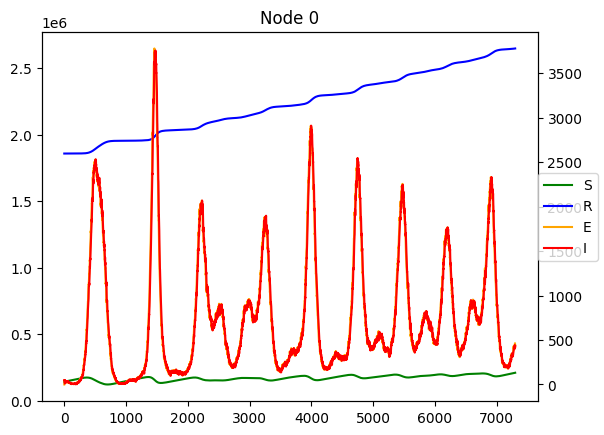

In [6]:
plot_channels(model2.report, node=0, ticks=params.ticks,twin=True)

vital_dynamics      :     430,854 μs
infection_update    :   2,005,917 μs
incubation_update   :   1,989,671 μs
transmission_update :  18,786,374 μs
report_update       :  29,732,233 μs
total               : 52,945,049 μs


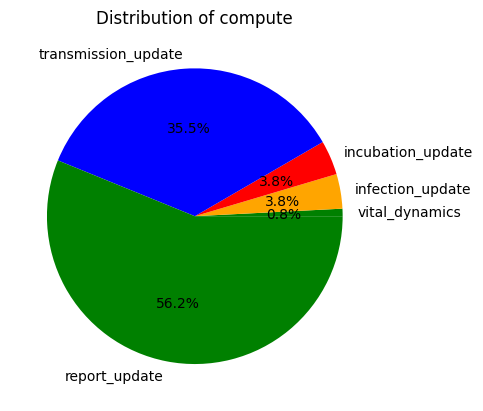

In [7]:
metrics = np.array(model2.metrics)
for c in range(metrics.shape[1]):
    if c == 0:
        continue
    print(f"{model2._phases[c-1].__name__:20}: {metrics[:,c].sum():11,} μs")
print("====================================")
print(f"total               : {metrics[:, 1:].sum():,} μs")
# metrics.sum(axis=0)[1:]
# import matplotlib.pyplot as plt

labels = [p.__name__ for p in model2._phases]
sizes = metrics.sum(axis=0)[1:]
colors = ["green", "orange", "red", "blue"]

plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%")
plt.title("Distribution of compute")
plt.show()